In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../data/raw"
processed_path: str = "../../data/processed"
df: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"all_apt_idx_recent_deposit.csv"))

In [3]:
df.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_ymd,recent_deposit,apt_idx,area,area_price,area_m2_price
0,0,72.320,201904,1,2,16,2016,36.977063,126.928605,3,17000.0,2019-04-01,-999.0,15,21.9,776.255708,235.066372
1,1,22.270,201904,1,2,11,2013,36.989441,126.842601,6,4000.0,2019-04-01,-999.0,36,6.7,597.014925,179.613830
2,2,59.940,201904,1,2,9,1996,37.126312,127.070305,23,9000.0,2019-04-01,-999.0,53,18.2,494.505495,150.150150
3,3,59.760,201904,1,2,1,1992,36.961599,126.918827,27,3000.0,2019-04-01,-999.0,64,18.1,165.745856,50.200803
4,4,58.764,201904,1,2,12,2005,37.589086,127.206811,14,18000.0,2019-04-01,-999.0,67,17.8,1011.235955,306.309986


In [4]:
# df의 크기 확인
print(f"df.shape = {df.shape}")
# recent_deposit이 -999인 행의 개수 확인
print(f"df[recent_deposit == -999].shape = {df[df.recent_deposit == -999].shape}")
print(f"df[deposit == -999].shape = {df[df.deposit == -999].shape}")

df.shape = (1951400, 17)
df[recent_deposit == -999].shape = (66842, 17)
df[deposit == -999].shape = (150172, 17)


* 군집 안돌리고 전체 train에서 가격 추이 구한뒤 간단한 모델로 추정

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951400 entries, 0 to 1951399
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
 11  contract_ymd         object 
 12  recent_deposit       float64
 13  apt_idx              int64  
 14  area                 float64
 15  area_price           float64
 16  area_m2_price        float64
dtypes: float64(8), int64(8), object(1)
memory usage: 253.1+ MB


In [6]:
df['contract_ymd'] = pd.to_datetime(df['contract_ymd'])
df

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_ymd,recent_deposit,apt_idx,area,area_price,area_m2_price
0,0,72.3200,201904,1,2,16,2016,36.977063,126.928605,3,17000.0,2019-04-01,-999.0,15,21.9,776.255708,235.066372
1,1,22.2700,201904,1,2,11,2013,36.989441,126.842601,6,4000.0,2019-04-01,-999.0,36,6.7,597.014925,179.613830
2,2,59.9400,201904,1,2,9,1996,37.126312,127.070305,23,9000.0,2019-04-01,-999.0,53,18.2,494.505495,150.150150
3,3,59.7600,201904,1,2,1,1992,36.961599,126.918827,27,3000.0,2019-04-01,-999.0,64,18.1,165.745856,50.200803
4,4,58.7640,201904,1,2,12,2005,37.589086,127.206811,14,18000.0,2019-04-01,-999.0,67,17.8,1011.235955,306.309986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,1951395,84.8086,202406,20,0,1,2022,37.604125,126.711206,2,-999.0,2024-06-20,30000.0,18460,25.7,-38.871595,-11.779466
1951396,1951396,84.9947,202406,20,0,20,2022,37.599620,126.706729,2,-999.0,2024-06-20,35000.0,18462,25.8,-38.720930,-11.753674
1951397,1951397,61.0093,202406,20,0,2,2024,37.885999,127.196120,0,-999.0,2024-06-20,-999.0,18536,18.5,-54.000000,-16.374553
1951398,1951398,58.0500,202406,20,0,3,1996,37.489146,126.886988,28,-999.0,2024-06-20,-999.0,18590,17.6,-56.761364,-17.209302


In [7]:
interest_rate_df = pd.read_csv(os.path.join(raw_path, "interestRate.csv"))
interest_rate_df

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


In [8]:
df['_type'] = np.where(df['deposit'] == -999, 'test', 'train')

In [9]:
# 'contract_ymd'를 기준으로 그룹화하여 월별 평균 deposit 계산
month_df = df.groupby(df['contract_ymd'].dt.to_period('M')).agg(avg_deposit=('deposit', 'mean')).reset_index()

# 일관성을 위해 'contract_ymd'를 다시 datetime 형식으로 변환
month_df['contract_ymd'] = month_df['contract_ymd'].dt.to_timestamp()

month_df

,contract_ymd,avg_deposit
0,2019-04-01,30447.425958
1,2019-05-01,31132.991601
2,2019-06-01,31111.287554
3,2019-07-01,31621.427691
4,2019-08-01,31712.702769
...,...,...
58,2024-02-01,-999.000000
59,2024-03-01,-999.000000
60,2024-04-01,-999.000000
61,2024-05-01,-999.000000


In [10]:
# 'year_month'를 datetime 형식으로 변환
interest_rate_df['year_month'] = pd.to_datetime(interest_rate_df['year_month'], format='%Y%m')

# 'contract_ymd'와 'year_month'를 기준으로 병합
month_df = pd.merge_asof(month_df.sort_values('contract_ymd'), 
                          interest_rate_df.sort_values('year_month'), 
                          left_on='contract_ymd', 
                          right_on='year_month', 
                          direction='backward')

# 필요 없는 'year_month' 열 삭제
month_df.drop(columns=['year_month'], inplace=True)

# 결측값이 있는 경우 이전 값으로 채우기
month_df['interest_rate'].fillna(method='ffill', inplace=True)

month_df

C:\Users\shgkd\AppData\Local\Temp\ipykernel_1900\4178289291.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  month_df['interest_rate'].fillna(method='ffill', inplace=True)
C:\Users\shgkd\AppData\Local\Temp\ipykernel_1900\4178289291.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  month_df['interest_rate'].fillna(method='ffill', inplace=True)


,contract_ymd,avg_deposit,interest_rate
0,2019-04-01,30447.425958,1.85
1,2019-05-01,31132.991601,1.85
2,2019-06-01,31111.287554,1.78
3,2019-07-01,31621.427691,1.68
4,2019-08-01,31712.702769,1.52
...,...,...,...
58,2024-02-01,-999.000000,3.62
59,2024-03-01,-999.000000,3.59
60,2024-04-01,-999.000000,3.54
61,2024-05-01,-999.000000,3.56


In [11]:
month_df['avg_deposit'].replace(-999, np.nan, inplace=True)
month_df

C:\Users\shgkd\AppData\Local\Temp\ipykernel_1900\4240536210.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  month_df['avg_deposit'].replace(-999, np.nan, inplace=True)


,contract_ymd,avg_deposit,interest_rate
0,2019-04-01,30447.425958,1.85
1,2019-05-01,31132.991601,1.85
2,2019-06-01,31111.287554,1.78
3,2019-07-01,31621.427691,1.68
4,2019-08-01,31712.702769,1.52
...,...,...,...
58,2024-02-01,NaN,3.62
59,2024-03-01,NaN,3.59
60,2024-04-01,NaN,3.54
61,2024-05-01,NaN,3.56


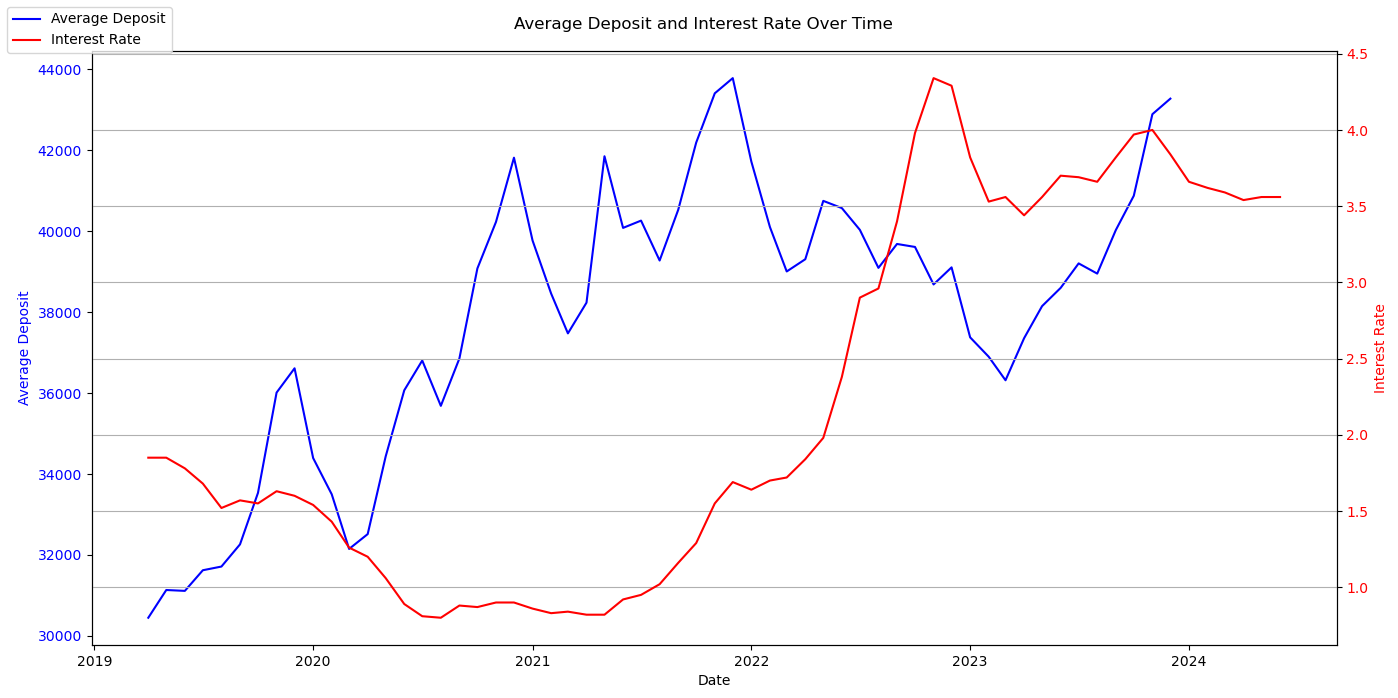

In [12]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot avg_deposit
ax1.plot(month_df['contract_ymd'], month_df['avg_deposit'], label='Average Deposit', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the interest rate
ax2 = ax1.twinx()
ax2.plot(month_df['contract_ymd'], month_df['interest_rate'], label='Interest Rate', color='red')
ax2.set_ylabel('Interest Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Average Deposit and Interest Rate Over Time')
fig.legend(loc='upper left')
fig.tight_layout()
plt.grid(True)
plt.show()

In [13]:
month_df = pd.read_csv(os.path.join(processed_path, "month_avg_deposit.csv"))
month_df['contract_ymd'] = pd.to_datetime(month_df['contract_ymd'])

d:\Program\Dev\ANACONDA\envs\apart\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


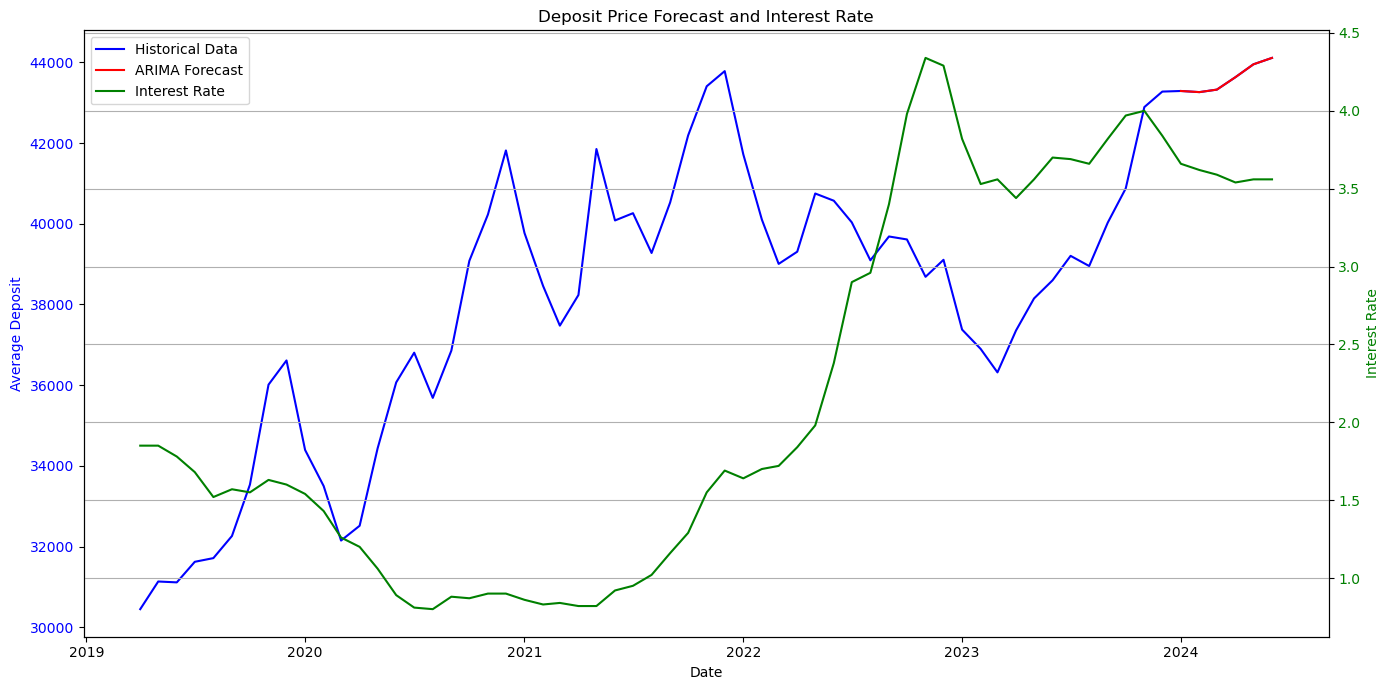

   contract_ymd         ARIMA
57   2024-01-01  43291.490926
58   2024-02-01  43263.557089
59   2024-03-01  43325.427232
60   2024-04-01  43633.720085
61   2024-05-01  43952.583381
62   2024-06-01  44111.736723


In [27]:
from statsmodels.tsa.arima.model import ARIMA

month_df = pd.read_csv(os.path.join(processed_path, "month_avg_deposit.csv"))
month_df['contract_ymd'] = pd.to_datetime(month_df['contract_ymd'])

# NaN 값을 가진 행을 제외하고 ARIMA 모델을 훈련
train_df = month_df.dropna(subset=['avg_deposit'])

# ARIMA 모델을 사용하여 avg_deposit 예측
model = ARIMA(train_df['avg_deposit'], order=(6, 1, 1))
model_fit = model.fit()

# NaN 값을 가진 행의 인덱스를 찾기
nan_indices = month_df[month_df['avg_deposit'].isna()].index

# NaN 값을 가진 행의 avg_deposit 예측
predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(nan_indices) - 1, typ='levels')

# 예측된 값을 month_df에 채우기
month_df.loc[nan_indices, 'avg_deposit'] = predictions.values

# 결과 데이터프레임 생성
results_df = month_df.loc[nan_indices].copy()
results_df['ARIMA'] = predictions.values

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 7))

# avg_deposit 그래프 (왼쪽 축)
ax1.plot(month_df['contract_ymd'], month_df['avg_deposit'], label='Historical Data', color='blue')
ax1.plot(results_df['contract_ymd'], results_df['ARIMA'], label='ARIMA Forecast', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# interest_rate 그래프 (오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(month_df['contract_ymd'], month_df['interest_rate'], label='Interest Rate', color='green')
ax2.set_ylabel('Interest Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 제목 및 범례
plt.title('Deposit Price Forecast and Interest Rate')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print(results_df[['contract_ymd', 'ARIMA']])

In [28]:
# 가장 이른 시점의 avg_deposit 값을 기준으로 설정
base_value = month_df['avg_deposit'].iloc[0]

# arima_deposit_index 컬럼 생성
month_df['arima_deposit_index'] = (month_df['avg_deposit'] / base_value) * 100

# 결과 확인
month_df

,contract_ymd,avg_deposit,interest_rate,arima_deposit_index
0,2019-04-01,30447.425958,1.85,100.000000
1,2019-05-01,31132.991601,1.85,102.251637
2,2019-06-01,31111.287554,1.78,102.180354
3,2019-07-01,31621.427691,1.68,103.855832
4,2019-08-01,31712.702769,1.52,104.155612
...,...,...,...,...
58,2024-02-01,43263.557089,3.62,142.092659
59,2024-03-01,43325.427232,3.59,142.295862
60,2024-04-01,43633.720085,3.54,143.308404
61,2024-05-01,43952.583381,3.56,144.355662


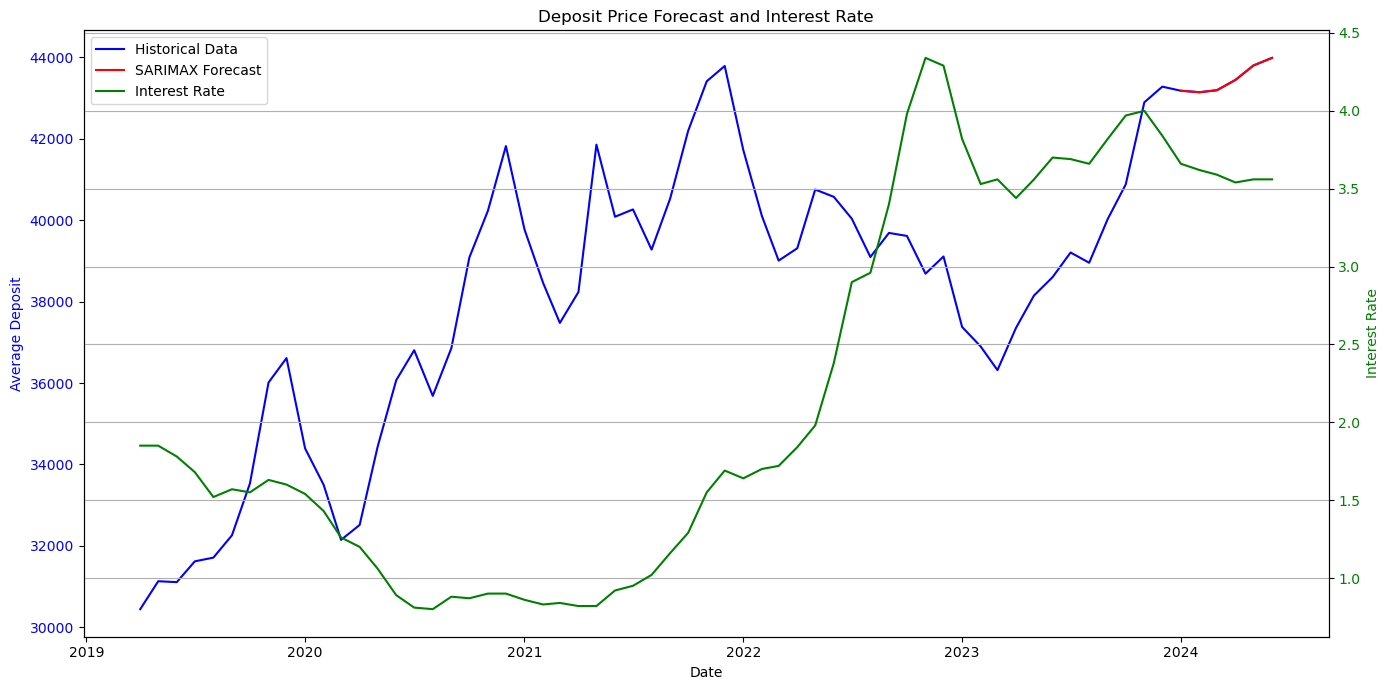

   contract_ymd       SARIMAX
57   2024-01-01  43176.590319
58   2024-02-01  43140.191961
59   2024-03-01  43188.983683
60   2024-04-01  43441.417290
61   2024-05-01  43796.555449
62   2024-06-01  43982.913202


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 데이터 로드
month_df2 = pd.read_csv(os.path.join(processed_path, "month_avg_deposit.csv"))
month_df2['contract_ymd'] = pd.to_datetime(month_df2['contract_ymd'])

# NaN 값을 가진 행을 제외하고 ARIMAX 모델을 훈련
train_df = month_df2.dropna(subset=['avg_deposit'])

# ARIMAX 모델을 사용하여 avg_deposit 예측
model = SARIMAX(train_df['avg_deposit'], 
                exog=train_df['interest_rate'],
                order=(6, 1, 1))
model_fit = model.fit()

# NaN 값을 가진 행의 인덱스를 찾기
nan_indices = month_df2[month_df2['avg_deposit'].isna()].index

# NaN 값을 가진 행의 avg_deposit 예측
exog_future = month_df2.loc[nan_indices, 'interest_rate']
predictions = model_fit.forecast(steps=len(nan_indices), exog=exog_future)

# 예측된 값을 month_df에 채우기
month_df2.loc[nan_indices, 'avg_deposit'] = predictions.values

# 결과 데이터프레임 생성
results_df = month_df2.loc[nan_indices].copy()
results_df['SARIMAX'] = predictions.values

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 7))

# avg_deposit 그래프 (왼쪽 축)
ax1.plot(month_df2['contract_ymd'], month_df2['avg_deposit'], label='Historical Data', color='blue')
ax1.plot(results_df['contract_ymd'], results_df['SARIMAX'], label='SARIMAX Forecast', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# interest_rate 그래프 (오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(month_df2['contract_ymd'], month_df2['interest_rate'], label='Interest Rate', color='green')
ax2.set_ylabel('Interest Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 제목 및 범례
plt.title('Deposit Price Forecast and Interest Rate')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print(results_df[['contract_ymd', 'SARIMAX']])

In [21]:
# 가장 이른 시점의 avg_deposit 값을 기준으로 설정
base_value = month_df2['avg_deposit'].iloc[0]

# arima_deposit_index 컬럼 생성
month_df2['sarimax_deposit_index'] = (month_df2['avg_deposit'] / base_value) * 100

# 결과 확인
month_df2

,contract_ymd,avg_deposit,interest_rate,sarimax_deposit_index
0,2019-04-01,30447.425958,1.85,100.000000
1,2019-05-01,31132.991601,1.85,102.251637
2,2019-06-01,31111.287554,1.78,102.180354
3,2019-07-01,31621.427691,1.68,103.855832
4,2019-08-01,31712.702769,1.52,104.155612
...,...,...,...,...
58,2024-02-01,43140.191961,3.62,141.687485
59,2024-03-01,43188.983683,3.59,141.847734
60,2024-04-01,43441.417290,3.54,142.676814
61,2024-05-01,43796.555449,3.56,143.843212


d:\Program\Dev\ANACONDA\envs\apart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Validation MAE: 898.3442210377847


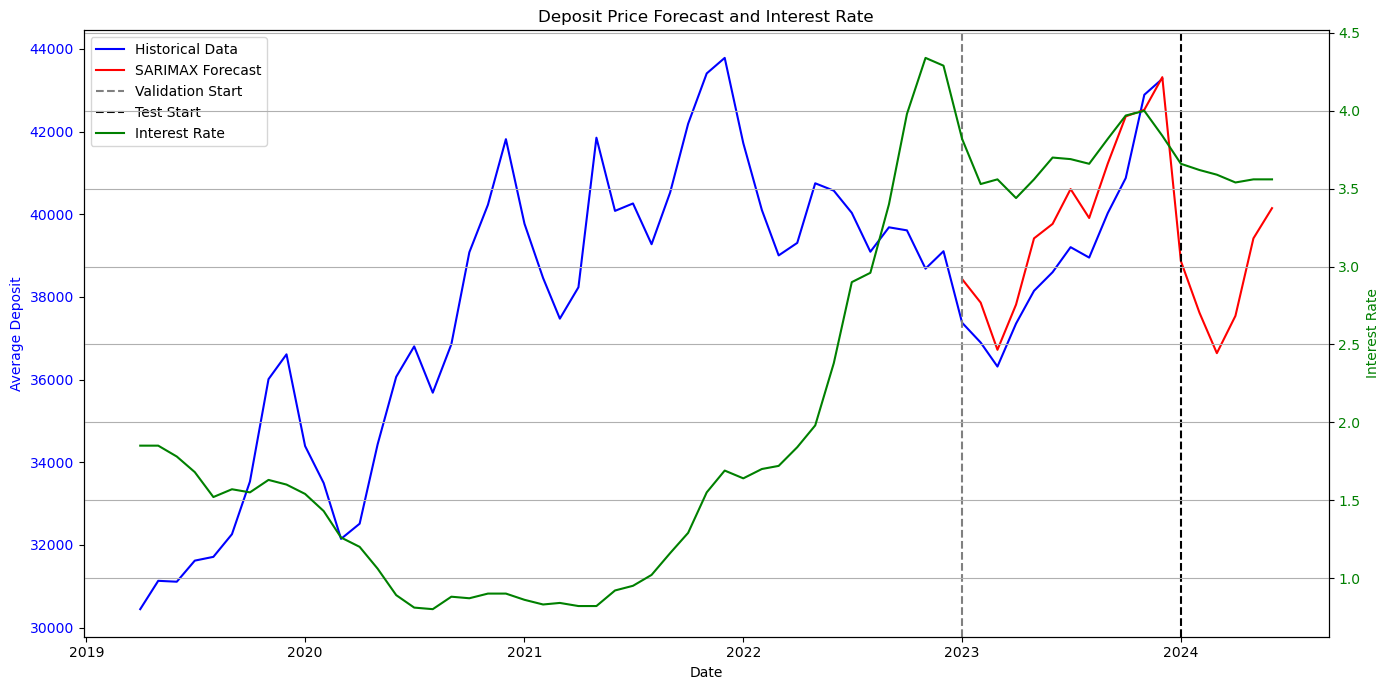

   contract_ymd   avg_deposit       SARIMAX
45   2023-01-01  37377.099149  38432.956682
46   2023-02-01  36897.616881  37863.209837
47   2023-03-01  36316.653675  36722.019890
48   2023-04-01  37356.163489  37815.450626
49   2023-05-01  38148.797547  39417.923465
50   2023-06-01  38600.180884  39767.996690
51   2023-07-01  39204.876290  40610.501161
52   2023-08-01  38952.732869  39910.414258
53   2023-09-01  40028.492926  41226.612810
54   2023-10-01  40876.997993  42369.185129
55   2023-11-01  42891.946646  42529.469280
56   2023-12-01  43276.737112  43317.731553
57   2024-01-01           NaN  38867.677533
58   2024-02-01           NaN  37618.679359
59   2024-03-01           NaN  36640.509730
60   2024-04-01           NaN  37543.750094
61   2024-05-01           NaN  39417.923465
62   2024-06-01           NaN  40148.377435


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# 데이터 로드
month_df = pd.read_csv(os.path.join(processed_path, "month_avg_deposit.csv"))
month_df['contract_ymd'] = pd.to_datetime(month_df['contract_ymd'])

# 데이터 분할
train_df = month_df[month_df['contract_ymd'] < '2023-01-01']
validation_df = month_df[(month_df['contract_ymd'] >= '2023-01-01') & (month_df['contract_ymd'] < '2024-01-01')]
test_df = month_df[month_df['contract_ymd'] >= '2024-01-01']

# SARIMAX 모델 훈련
model = SARIMAX(train_df['avg_deposit'], 
                exog=train_df['interest_rate'],
                order=(2, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=True, 
                enforce_invertibility=True)
model_fit = model.fit()

# Validation set 예측
validation_exog = validation_df['interest_rate']
validation_predictions = model_fit.forecast(steps=len(validation_df), exog=validation_exog)

# Test set 예측
test_exog = test_df['interest_rate']
test_predictions = model_fit.forecast(steps=len(test_df), exog=test_exog)

# Validation MAE 계산
validation_mae = mean_absolute_error(validation_df['avg_deposit'], validation_predictions)
print(f"Validation MAE: {validation_mae}")

# 결과 데이터프레임 생성
results_df = pd.concat([validation_df, test_df])
results_df['SARIMAX'] = np.concatenate([validation_predictions, test_predictions])

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 7))

# avg_deposit 그래프 (왼쪽 축)
ax1.plot(month_df['contract_ymd'], month_df['avg_deposit'], label='Historical Data', color='blue')
ax1.plot(results_df['contract_ymd'], results_df['SARIMAX'], label='SARIMAX Forecast', color='red')
ax1.axvline(x=pd.to_datetime('2023-01-01'), color='gray', linestyle='--', label='Validation Start')
ax1.axvline(x=pd.to_datetime('2024-01-01'), color='black', linestyle='--', label='Test Start')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# interest_rate 그래프 (오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(month_df['contract_ymd'], month_df['interest_rate'], label='Interest Rate', color='green')
ax2.set_ylabel('Interest Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 제목 및 범례
plt.title('Deposit Price Forecast and Interest Rate')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print(results_df[['contract_ymd', 'avg_deposit', 'SARIMAX']])

d:\Program\Dev\ANACONDA\envs\apart\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\Program\Dev\ANACONDA\envs\apart\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


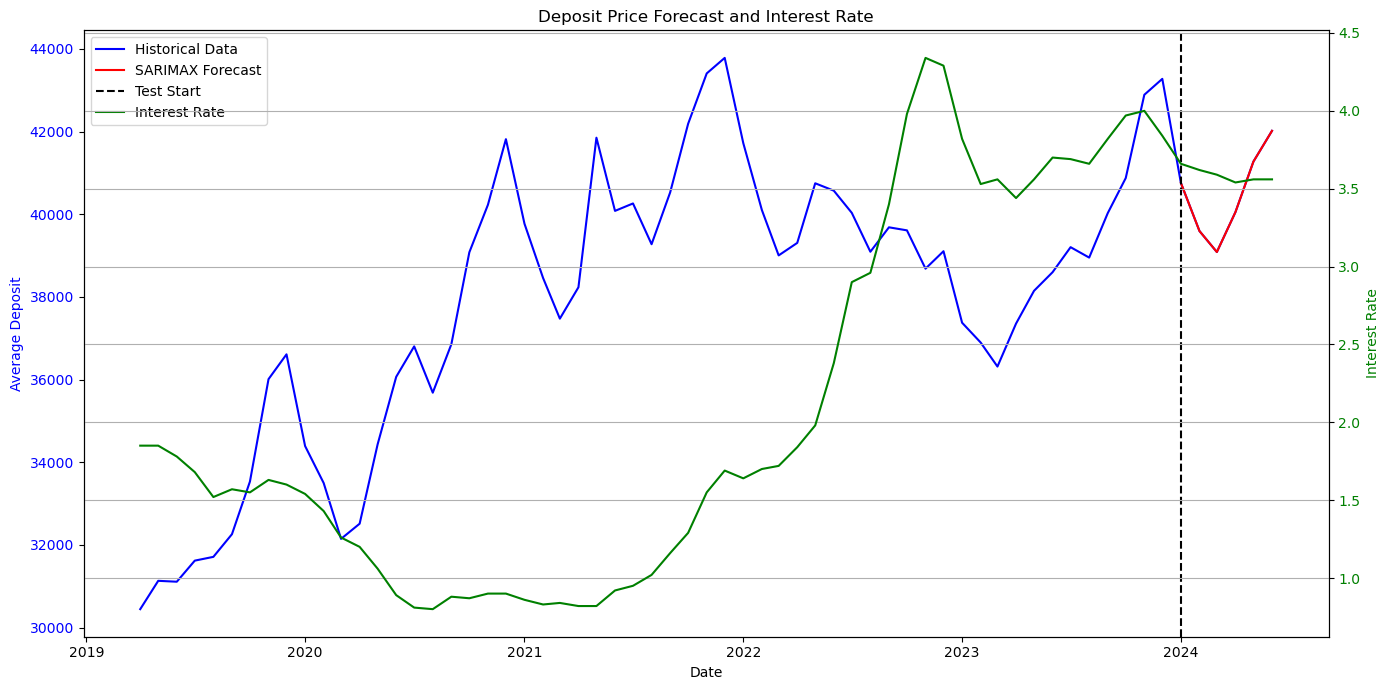

   contract_ymd  avg_deposit       SARIMAX
57   2024-01-01          NaN  40758.564640
58   2024-02-01          NaN  39595.405212
59   2024-03-01          NaN  39087.445561
60   2024-04-01          NaN  40052.989878
61   2024-05-01          NaN  41275.032186
62   2024-06-01          NaN  42019.656979


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# 데이터 로드
month_df3 = pd.read_csv(os.path.join(processed_path, "month_avg_deposit.csv"))
month_df3['contract_ymd'] = pd.to_datetime(month_df3['contract_ymd'])

# 데이터 분할
train_df = month_df3[month_df3['contract_ymd'] < '2024-01-01']
test_df = month_df3[month_df3['contract_ymd'] >= '2024-01-01']

# SARIMAX 모델 훈련
model = SARIMAX(train_df['avg_deposit'], 
                exog=train_df['interest_rate'],
                order=(2, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=True, 
                enforce_invertibility=True)
model_fit = model.fit()

# Test set 예측
test_exog = test_df['interest_rate']
test_predictions = model_fit.forecast(steps=len(test_df), exog=test_exog)

# 결과 데이터프레임 생성
results_df = test_df.copy()
results_df['SARIMAX'] = test_predictions.values

# month_df3의 NaN 값을 results_df의 SARIMAX 값으로 채우기
month_df3.loc[month_df3['avg_deposit'].isna(), 'avg_deposit'] = results_df['SARIMAX'].values

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 7))

# avg_deposit 그래프 (왼쪽 축)
ax1.plot(month_df3['contract_ymd'], month_df3['avg_deposit'], label='Historical Data', color='blue')
ax1.plot(results_df['contract_ymd'], results_df['SARIMAX'], label='SARIMAX Forecast', color='red')
ax1.axvline(x=pd.to_datetime('2024-01-01'), color='black', linestyle='--', label='Test Start')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# interest_rate 그래프 (오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(month_df3['contract_ymd'], month_df3['interest_rate'], label='Interest Rate', color='green')
ax2.set_ylabel('Interest Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 제목 및 범례
plt.title('Deposit Price Forecast and Interest Rate')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 출력
print(results_df[['contract_ymd', 'avg_deposit', 'SARIMAX']])

In [26]:
# 가장 이른 시점의 avg_deposit 값을 기준으로 설정
base_value = month_df3['avg_deposit'].iloc[0]

# arima_deposit_index 컬럼 생성
month_df3['sarimax_deposit_index'] = (month_df3['avg_deposit'] / base_value) * 100

# 결과 확인
month_df3

,contract_ymd,avg_deposit,interest_rate,sarimax_deposit_index
0,2019-04-01,30447.425958,1.85,100.000000
1,2019-05-01,31132.991601,1.85,102.251637
2,2019-06-01,31111.287554,1.78,102.180354
3,2019-07-01,31621.427691,1.68,103.855832
4,2019-08-01,31712.702769,1.52,104.155612
...,...,...,...,...
58,2024-02-01,39595.405212,3.62,130.045165
59,2024-03-01,39087.445561,3.59,128.376847
60,2024-04-01,40052.989878,3.54,131.548033
61,2024-05-01,41275.032186,3.56,135.561647


In [29]:
# month_df에 month_df3의 sarimax_deposit_index 열을 contract_ymd를 기준으로 병합
month_df = month_df.merge(month_df3[['contract_ymd', 'sarimax_deposit_index']], on='contract_ymd', how='left')

# 결과 확인
month_df

,contract_ymd,avg_deposit,interest_rate,arima_deposit_index,sarimax_deposit_index
0,2019-04-01,30447.425958,1.85,100.000000,100.000000
1,2019-05-01,31132.991601,1.85,102.251637,102.251637
2,2019-06-01,31111.287554,1.78,102.180354,102.180354
3,2019-07-01,31621.427691,1.68,103.855832,103.855832
4,2019-08-01,31712.702769,1.52,104.155612,104.155612
...,...,...,...,...,...
58,2024-02-01,43263.557089,3.62,142.092659,130.045165
59,2024-03-01,43325.427232,3.59,142.295862,128.376847
60,2024-04-01,43633.720085,3.54,143.308404,131.548033
61,2024-05-01,43952.583381,3.56,144.355662,135.561647


In [31]:
# month_df를 CSV 파일로 저장
month_df.to_csv(os.path.join(processed_path, "month_df_arima_index.csv"), index=False)